# Raízen Technical Challenge

This project refers to a challenge proposed by Raízen for a senior data science analyst role. 

The main goal of the challenge is to explore data from NYC metro and to build a machine learning model to predict the number of people that use the metro, so we can conclude that we have a **regression problem**.

To do this, we are going to use a history from 2010 to 2017 about the metro usage. To complete the challenge, our structured approach os going to be the following:

**Approach**
1. Exploratory Data Analysis (EDA)
2. Baseline Machine Learning Model
3. Feature engineering
4. New model after feature engineering
5. Feature selection
6. New model after feature selection
7. Hyperparameter tunning
8. Check overfitting with a test set
9. Final adjustments
10. Deploy in a streamlit application

In [1]:
#setup - libraries import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Data Loading

For convenience, we executed the unzip of all folders downloaded from the challenge drive link. All the csv's were put in a unique folder, so we can read all of them from a unique directory.

For EDA, we are going to read, at first, each year csv and see what we got in each one.

#### 2010 csv

In [2]:
#loading 2010 csv
df_2010 = pd.read_csv("../dados_desafio/csvs/2010.csv")
df_2010.head(3)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0


In [11]:
#checking some dataset information
df_2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      object 
 1   ca        object 
 2   unit      object 
 3   scp       object 
 4   station   object 
 5   linename  object 
 6   division  object 
 7   desc      object 
 8   entries   float64
 9   exits     float64
 10  flow      float64
dtypes: float64(3), object(8)
memory usage: 622.7+ MB


In [12]:
#checking some dataset information
df_2010.shape

(7420384, 11)

We cannot ignore the fact that we have a really big dataset. This observation is going to be essential for our later definitions about how to define and approach our problem.

In [9]:
#number of missing values
df_2010.isna().sum()

time            0
ca              0
unit            0
scp             0
station     10148
linename    10148
division    10148
desc            0
entries         0
exits           0
dtype: int64

In [10]:
#let's check the percentual of missing values related to our complete dataset
#we will consider the worst scenario: there is no intersection between the nas in station, linename and division
nas = 10148*3
total_len = 7420384

print(f"percentual of missing values: {nas*100/total_len}%")

percentual of missing values: 0.41027526338259585%


It is a really small percentual of nas. In this case, we will decide to just drop it all.

In [3]:
#dropping nas
df_2010 = df_2010.dropna()
df_2010.shape

(7410236, 10)

In [5]:
#now let's take our first look at the entries column using the describe function
df_2010["entries"].describe()

count    7.420384e+06
mean     2.937674e+06
std      3.241264e+06
min     -1.473643e+07
25%      4.714210e+05
50%      1.907578e+06
75%      4.371914e+06
max      3.312192e+07
Name: entries, dtype: float64

In [7]:
#now let's take our first look at the exits column using the describe function
df_2010["exits"].describe()

count    7.420384e+06
mean     2.445276e+06
std      6.177387e+06
min     -1.447243e+08
25%      2.817950e+05
50%      1.252143e+06
75%      3.284071e+06
max      3.303235e+08
Name: exits, dtype: float64

It seems a bit strange that the columns "entries" and "exits" both have negative values.

In [4]:
#counting the number of negative numbers in entries and exits
negative_entries = df_2010.loc[df_2010["entries"] < 0].shape[0]
negative_exits = df_2010.loc[df_2010["exits"] < 0].shape[0]

print(f"total negative entries: {negative_entries}")
print(f"total negative exits: {negative_exits}")

total negative entries: 1
total negative exits: 1659


So there are a significant amount of negative exits. Let's keep this information in mind and move on to see what we can do with this later.

We are going to assume that these columns cannot have negative values. So, at first, we will just filter these columns from our dataframe.

In [4]:
#filtering our dataset
df_2010 = df_2010[df_2010["entries"] >= 0]
df_2010 = df_2010[df_2010["exits"] >= 0]

#checking our shape after our filter
df_2010.shape

(7408576, 10)

To continue the exploratory analysis, we will start with the definition that our target is the flow of people in a given date and time, given by the sum of entries and exits. But entries and exits are cumulative quantities, as the challenge description defined for us. After some googling about the specifics of a metro usage analysis, we have found out that to know the real number of, for example, entries in a certain time of a day, we need to subtract the current number of entries from the previous hour. Before we do this, we need to find out what can serve as an unique id to be used combined with the time column.

According to the challenge and data description, the columns that we can use as a species of primary keys to differ instances over time are "ca", "station", "scp" and "linename". Now, we are going to use this to transform entries and exits as we need.

In [5]:
#first variable: entries

#defining some variables for our calculation
ids = ["ca", "station", "scp", "linename"]
variable = "entries"

#creating the feature
df_2010["real_entries"] = df_2010.groupby(ids)[variable].diff()

In [6]:
#second variable: exits

#defining some variables for our calculation
ids = ["ca", "station", "scp", "linename"]
variable = "exits"

#creating the feature
df_2010["real_exits"] = df_2010.groupby(ids)[variable].diff()

**Transform Check**

We are going to do a check to see if our transform has worked fine. We will do this taking a random station.

In [7]:
#checking the amount of different stations
len(df_2010["station"].unique())

382

In [9]:
#randomly choosing a station to execute some checks
#generate a random index
rdm = np.random.randint(0, 382)

#getting a list with all stations
stations = list(df_2010["station"].unique())

#randomly choosing our station
st = stations[rdm]

#checking the station data
df = df_2010[df_2010["station"]==st]
df.head(2)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,real_entries,real_exits
3354,2010-04-17 05:00:00,N551,R421,00-00-00,AVE I,F,IND,REGULAR,4478792.0,2317394.0,NaN,NaN
3355,2010-04-17 05:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457092.0,1639709.0,NaN,NaN


Our selected station was AVE I. What we wanna discover here is how we can identify a unique combination with the columns time and station. Which other columns do we need to create a set of unique ids?

In [7]:
#let's take an example to see if our transformation worked fine
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]
df_check.head(15)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,real_entries,real_exits
3355,2010-04-17 05:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457092.0,1639709.0,NaN,NaN
9303,2010-04-17 09:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457092.0,1639710.0,0.0,1.0
14246,2010-04-17 13:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457128.0,1639723.0,36.0,13.0
19311,2010-04-17 17:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457188.0,1639751.0,60.0,28.0
24207,2010-04-17 21:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457248.0,1639797.0,60.0,46.0
29649,2010-04-18 01:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457295.0,1639836.0,47.0,39.0
34578,2010-04-18 05:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457315.0,1639858.0,20.0,22.0
40508,2010-04-18 09:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457317.0,1639864.0,2.0,6.0
45283,2010-04-18 13:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457348.0,1639878.0,31.0,14.0
50188,2010-04-18 17:00:00,N551,R421,00-00-01,AVE I,F,IND,REGULAR,2457427.0,1639913.0,79.0,35.0


Ok, it seems like our transformation has wored properly when we look at the new columns.

Now, we will create what is gonna be our target feature, which will be called "people_flow". It is defined as the following:

```
people_flow = real_entries + real_exits
```

In [7]:
#the function diff() generates missing values for the first rows.
#As these first rows are our start point, we will fill the new columns missing values with 0.
df_2010["real_entries"] = df_2010["real_entries"].fillna(0)
df_2010["real_exits"] = df_2010["real_exits"].fillna(0)

In [8]:
#creating our target column
df_2010["people_flow"] = df_2010["real_entries"] + df_2010["real_exits"]
df_2010["people_flow"] = df_2010["people_flow"].round(2)

In [26]:
#checking the statistics about the new column
df_2010["people_flow"].describe()

count    7.408576e+06
mean     1.286147e+02
std      9.673019e+04
min     -1.342176e+08
25%      1.100000e+01
50%      1.280000e+02
75%      4.070000e+02
max      1.342177e+08
Name: people_flow, dtype: float64

Checking our describe output, we can conclude that we got some outliers. Let's count them:

In [27]:
#counting negative values
print(f"total negative values: {df_2010[df_2010['people_flow']<0].shape[0]}")

total negative values: 871


In [28]:
#counting huge values
print(f"total huge values: {df_2010[df_2010['people_flow']>50000].shape[0]}")

total huge values: 259


Ok, there are not so many of them. In this case, we are just going to drop them. But for the high values, we will use a thresold of 50.000 and here is the why:

1. When we are bulding forecasting models, outliers can be important to indicate behaviors that rely on events like holidays, sales promotion, black friday and so on;

2. Bringing up a spoiler, our idea is to use a boosting model to make the predictions in the modelling phase. Despite the fact that tree-based models can handle outliers without too much pre processing, when these outliers are in the target feature, it can impact the gradient descent process and create noise in the training task;

3. Sometimes it is a bit hard for human beings detect all the dynamics in a database, so let's keep some outliers and let our ML model to identify the hidden patterns involving this kind of information.

In [9]:
#dropping what we defined as outliers
df_2010 = df_2010[(df_2010["people_flow"]<50000)&(df_2010["people_flow"]>=0)]
df_2010.shape

(7407446, 13)

### Visual Analysis

Now that we preprocessed our target column, let's take some examples to visually analyze our data.

In [36]:
#taking a station and a scp as example
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]
df_check.shape

(1609, 13)

Text(0.5, 1.0, 'Daily flow - AVE I 00-00-01')

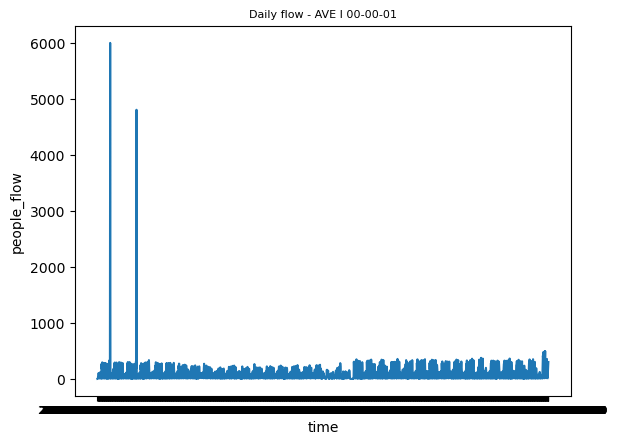

In [33]:
#we will see our target feature over time with our whole data
#visualizing our data
sns.lineplot(x="time", y="people_flow", data=df_check)
plt.xticks(fontsize=8)
plt.title("Daily flow - AVE I 00-00-01", fontsize=8)

Despite the fact that we can start to see some patterns in the data, our figure is really bad!, Let's try to take a smaller period to check our data

Text(0.5, 1.0, 'Daily flow - AVE I 00-00-01')

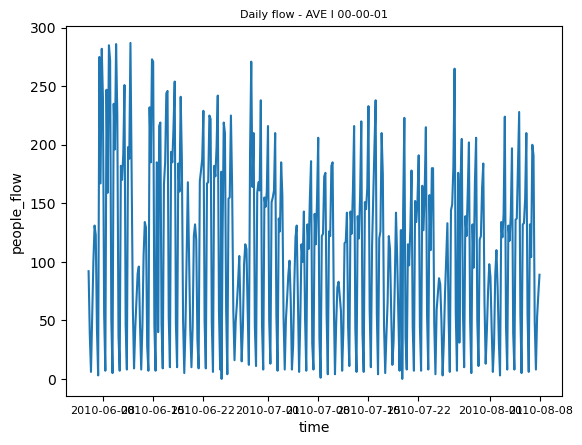

In [37]:
#filtering a period
start = pd.to_datetime("2010-06-06")
end = pd.to_datetime("2010-08-08")

df_check["time"] = pd.to_datetime(df_check["time"], format="%Y-%m-%d %H:%M:%S")
df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

sns.lineplot(x="time", y="people_flow", data=df_check)
plt.xticks(fontsize=8)
plt.title("Daily flow - AVE I 00-00-01", fontsize=8)

OK, the figure is better now, we can see a bit more clear a periodic pattern but we definetly could do better. Let'see what happens within a month.

Text(0.5, 1.0, 'Daily flow - AVE I 00-00-01')

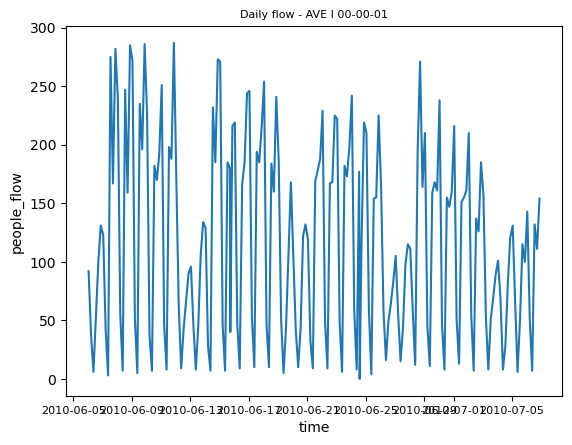

In [38]:
#filtering a period
start = pd.to_datetime("2010-06-06")
end = pd.to_datetime("2010-07-07")

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

sns.lineplot(x="time", y="people_flow", data=df_check)
plt.xticks(fontsize=8)
plt.title("Daily flow - AVE I 00-00-01", fontsize=8)

That is intersting! We can clearly see a cyclic pattern within the month. But what do we have when we analyze data over month? Let's take a look

In [39]:
#converting time to datetime
df_2010["time"] = pd.to_datetime(df_2010["time"], format="%Y-%m-%d %H:%M:%S")

#creating a feature with month
df_2010["month"] = df_2010["time"].dt.month

In [40]:
#creating df_check again
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]
df_check.shape

(1609, 14)

In [41]:
#creating a group by month
df_month = pd.DataFrame(df_2010.groupby(["month"])["people_flow"].sum().rename("monthly_people_flow"))
df_month = df_month.reset_index()
df_month = df_month.sort_values(by="month", ascending=True)
df_month.head()

,month,monthly_people_flow
0,4,60908563.0
1,5,317370303.0
2,6,264425189.0
3,7,257268146.0
4,8,251149559.0


<AxesSubplot:xlabel='month', ylabel='monthly_people_flow'>

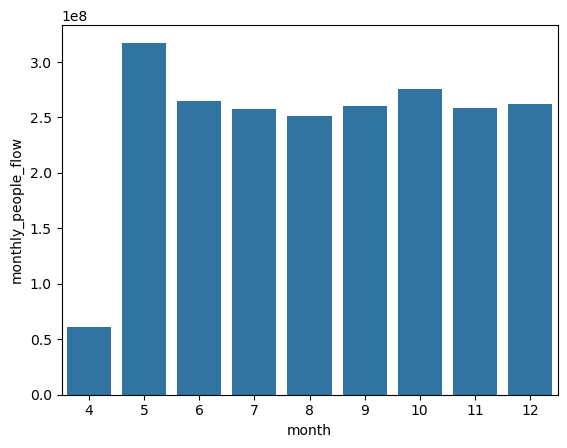

In [42]:
#generating the view
sns.barplot(x="month", y="monthly_people_flow", data=df_month)

In this chart we can desconsider the month 4 (April) because it was our start point when we executed the diff() transform. 

Looking at the sum of flow over months we cannot see a pattern as clear as we see within a month. Now we are going to see how is the dynamic inside the day and the week.

Text(0.5, 1.0, 'Daily flow - AVE I 00-00-01')

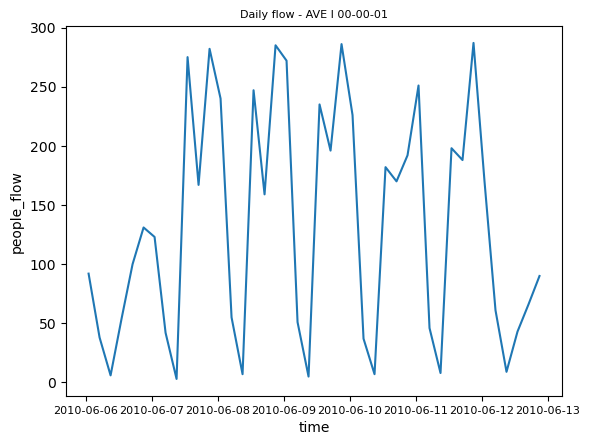

In [43]:
#filtering a period
start = pd.to_datetime("2010-06-06")
end = pd.to_datetime("2010-06-13")

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

sns.lineplot(x="time", y="people_flow", data=df_check)
plt.xticks(fontsize=8)
plt.title("Daily flow - AVE I 00-00-01", fontsize=8)

It comes to attention that 06-06-2023 and 13-06-2023 have significant lower values. Taking a look on the calendar, we can observe that both two days are Sunday. Maybe the day of week is also an important feature. We should see other time frames to see if it happens in a consistent way.

Text(0.5, 1.0, 'Daily flow - AVE I 00-00-01')

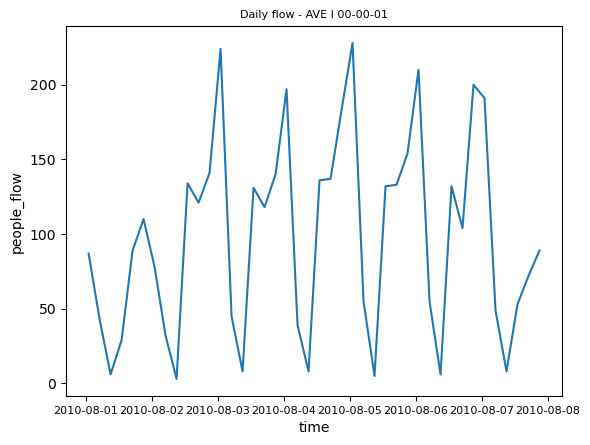

In [47]:
#creating df_check again
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]

#filtering a period
start = pd.to_datetime("2010-08-01", dayfirst=False)
end = pd.to_datetime("2010-08-08", dayfirst=False)

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

#generating the chart
sns.lineplot(x="time", y="people_flow", data=df_check)
plt.xticks(fontsize=8)
plt.title("Daily flow - AVE I 00-00-01", fontsize=8)

Again, 01-08-2010 and 08-08-2010 are Sundays.

Text(0.5, 1.0, 'Daily flow - AVE I 00-00-01')

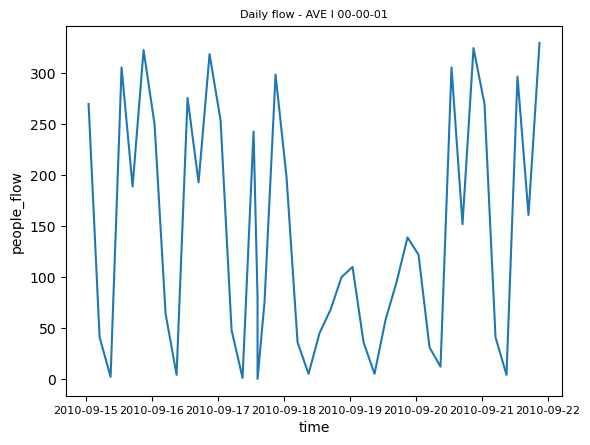

In [48]:
#creating df_check again
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]

#filtering a period
start = pd.to_datetime("2010-09-15", dayfirst=False)
end = pd.to_datetime("2010-09-22", dayfirst=False)

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

#generating the chart
sns.lineplot(x="time", y="people_flow", data=df_check)
plt.xticks(fontsize=8)
plt.title("Daily flow - AVE I 00-00-01", fontsize=8)

19-09-2023 is a Sunday. OK, we can be convinced that sunday is a less busy day in the metro, so our day of week may be an important feature. Now let's see what happens within a day.

Text(0.5, 1.0, 'intradaily flow - AVE I 00-00-01')

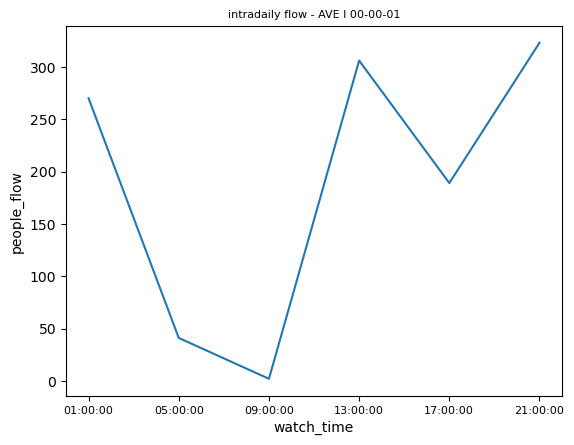

In [52]:
#extracting only date
df_check["date"] = df_check["time"].dt.date
df_check["watch_time"] = df_check["time"].dt.time
df_check["date"] = pd.to_datetime(df_check["date"], dayfirst=False)
df_check["watch_time"] = df_check["watch_time"].astype("str")

#filtering by date
df_filter = df_check[df_check["date"] == pd.to_datetime("2010-09-15")]

#visualizing our data
sns.lineplot(x="watch_time", y="people_flow", data=df_filter)
plt.xticks(fontsize=8)
plt.title("intradaily flow - AVE I 00-00-01", fontsize=8)

Text(0.5, 1.0, 'intradaily flow - AVE I 00-00-01')

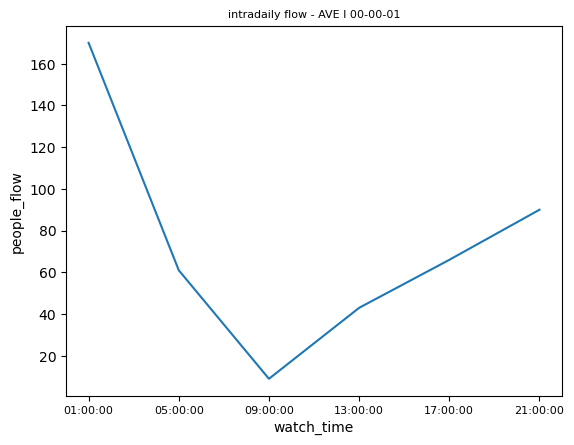

In [53]:
#let's check other days

#creating df_check again
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]

#filtering a period
start = pd.to_datetime("2010-06-06", dayfirst=False)
end = pd.to_datetime("2010-06-13", dayfirst=False)

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

#extracting only date
df_check["date"] = df_check["time"].dt.date
df_check["watch_time"] = df_check["time"].dt.time
df_check["date"] = pd.to_datetime(df_check["date"], dayfirst=False)
df_check["watch_time"] = df_check["watch_time"].astype("str") #we need this to use as x-axis label

#filtering by date
df_filter = df_check[df_check["date"] == pd.to_datetime("2010-06-12")]

#visualizing our data
sns.lineplot(x="watch_time", y="people_flow", data=df_filter)
plt.xticks(fontsize=8)
plt.title("intradaily flow - AVE I 00-00-01", fontsize=8)

Text(0.5, 1.0, 'intradaily flow - AVE I 00-00-01')

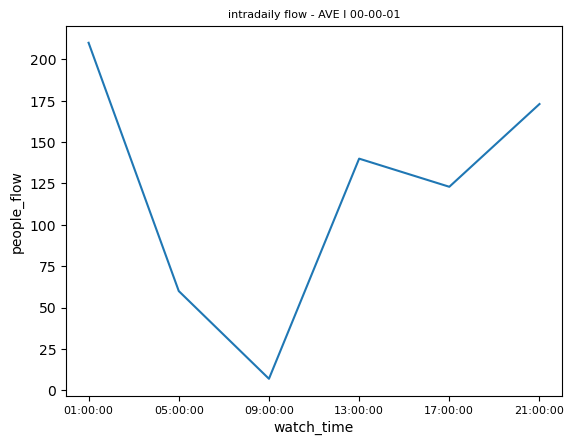

In [54]:
#let's check other days

#creating df_check again
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]

#filtering a period
start = pd.to_datetime("2010-08-25", dayfirst=False)
end = pd.to_datetime("2010-08-26", dayfirst=False)

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

#extracting only date
df_check["date"] = df_check["time"].dt.date
df_check["watch_time"] = df_check["time"].dt.time
df_check["date"] = pd.to_datetime(df_check["date"], dayfirst=False)
df_check["watch_time"] = df_check["watch_time"].astype("str") #we need this to use as x-axis label

#filtering by date
df_filter = df_check[df_check["date"] == pd.to_datetime("2010-08-25")]

#visualizing our data
sns.lineplot(x="watch_time", y="people_flow", data=df_filter)
plt.xticks(fontsize=8)
plt.title("intradaily flow - AVE I 00-00-01", fontsize=8)

Text(0.5, 1.0, 'intradaily flow - AVE I 00-00-01')

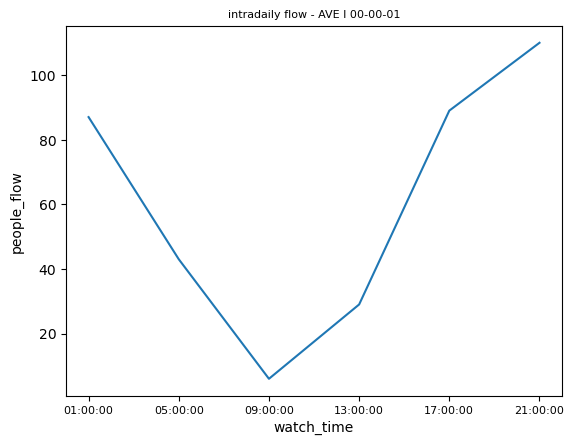

In [55]:
#let's check a sunday

#creating df_check again
station = "AVE I"
scp = "00-00-01"

df_check = df_2010[(df_2010["station"]==station)&(df_2010["scp"]==scp)]

#filtering a period
start = pd.to_datetime("2010-08-01", dayfirst=False)
end = pd.to_datetime("2010-08-02", dayfirst=False)

df_check = df_check[(df_check["time"] >= start)&(df_check["time"] <= end)]

#extracting only date
df_check["date"] = df_check["time"].dt.date
df_check["watch_time"] = df_check["time"].dt.time
df_check["date"] = pd.to_datetime(df_check["date"], dayfirst=False)
df_check["watch_time"] = df_check["watch_time"].astype("str") #we need this to use as x-axis label

#filtering by date
df_filter = df_check[df_check["date"] == pd.to_datetime("2010-08-01")]

#visualizing our data
sns.lineplot(x="watch_time", y="people_flow", data=df_filter)
plt.xticks(fontsize=8)
plt.title("intradaily flow - AVE I 00-00-01", fontsize=8)

Looking at intraday data, we see a repeatable pattern, what takes us to the conclusion that we have daily dynamics.

### Checking the dynamics among the stations

In [14]:
#creating a dataframe with the stations and the sum of peoplo_flow
df_stations = pd.DataFrame(df_2010.groupby(["station"])["people_flow"].sum().rename("total_flow_station"))
df_stations = df_stations.reset_index()

#sorting our data from in a descending way
df_stations = df_stations.sort_values(by="total_flow_station", ascending=False)

#we are going to select just the top 10 stations
df_stations = df_stations.head(10)

In [15]:
#just for convenience, we are going to normalize our data
max_value = df_stations["total_flow_station"].max()
df_stations["total_flow_station"] = df_stations["total_flow_station"]/max_value

Text(0.5, 1.0, 'Flow of people per station')

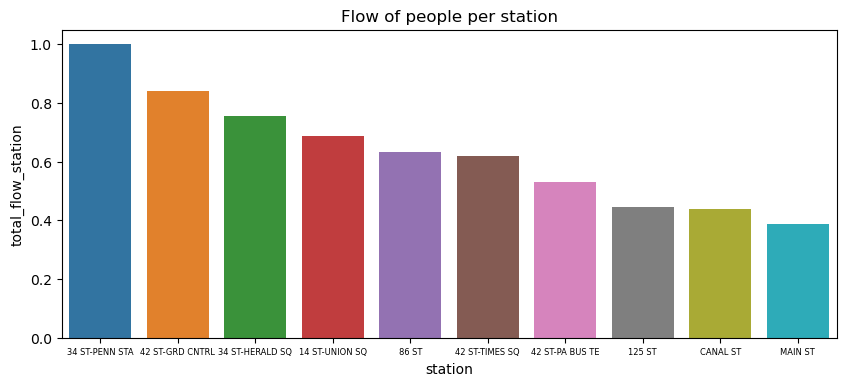

In [21]:
#creating the chart
plt.figure(figsize=(10, 4))
sns.barplot(x="station", y="total_flow_station", hue="station", data=df_stations)
plt.xticks(fontsize=6)
plt.title("Flow of people per station")

As we could expect, each station has a level of how busy each one is. For sure it is going to be a relevant feature for our machine learning model.

We can performthe same analysis for the lines.

In [22]:
#creating a dataframe with the lines and the sum of peoplo_flow
df_lines = pd.DataFrame(df_2010.groupby(["linename"])["people_flow"].sum().rename("total_flow_line"))
df_lines = df_lines.reset_index()

#sorting our data from in a descending way
df_lines = df_lines.sort_values(by="total_flow_line", ascending=False)

#we are going to select just the top 10 stations
df_lines = df_lines.head(10)

In [23]:
#just for convenience, we are going to normalize our data
max_value = df_lines["total_flow_line"].max()
df_lines["total_flow_line"] = df_lines["total_flow_line"]/max_value

Text(0.5, 1.0, 'Flow of people per line')

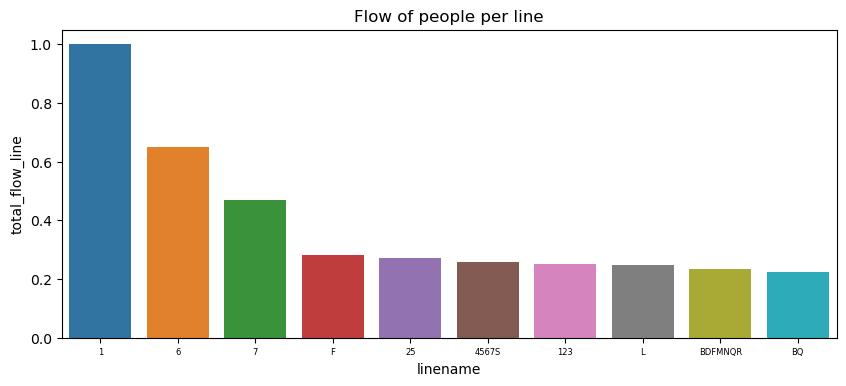

In [24]:
#creating the chart
plt.figure(figsize=(10, 4))
sns.barplot(x="linename", y="total_flow_line", hue="linename", data=df_lines)
plt.xticks(fontsize=6)
plt.title("Flow of people per line")

The same way that we can see the levels of flow in each station, we have it for lines also. Despite the fact that, just looking at the chart, which stations the linename "1" belongs to, we can agree that lines also have an impact on the flow of people and must be as feature for our ML model.

### Conclusions from EDA

From our analysis, we can make some conclusions already. The first one and maybe the most important is that, given that we have a huge database, our next steps are going to be based on **daily usage per station and line**. Given that, we will need to consolidate our data by the sum of usage per day for each station.

The second one is about temporal dynamics. We were able to see that daily, weekly and monthly patterns are very present in our data, so all of features will be considered in our feature engineering process.

In [12]:
#converting time to datetime
df_2010["time"] = pd.to_datetime(df_2010["time"], format="%Y-%m-%d %H:%M:%S")

#extracting only date
df_2010["date"] = df_2010["time"].dt.date

In [14]:
#consolidating data by date, station and line
#dropping time column - we won't need it anymore
df_2010 = df_2010.drop(columns="time", axis=1)

#consolidating
df_final = pd.DataFrame(df_2010.groupby(["date", "station", "linename"]).sum(numeric_only=True))
df_final = df_final.reset_index()
df_final.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow
0,2010-04-17,1 AVE,L,265071111.0,224481314.0,8179.0,9088.0,17267.0
1,2010-04-17,103 ST,1,195542531.0,106410762.0,6570.0,2408.0,8978.0
2,2010-04-17,103 ST,6,144693237.0,150159494.0,6740.0,5891.0,12631.0


In [15]:
#checking how much we reduced memory usage after taking these assumptions about our data consolidating process
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116692 entries, 0 to 116691
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          116692 non-null  object 
 1   station       116692 non-null  object 
 2   linename      116692 non-null  object 
 3   entries       116692 non-null  float64
 4   exits         116692 non-null  float64
 5   real_entries  116692 non-null  float64
 6   real_exits    116692 non-null  float64
 7   people_flow   116692 non-null  float64
dtypes: float64(5), object(3)
memory usage: 7.1+ MB


In [16]:
#checking shape
df_final.shape

(116692, 8)

We reduced our memory usage from 600MB to 7MB. This is important because, for this challenge, we do not have powerful computational resources to build our machine learning models. We still have 6 other databases to concatenate and it would make difficult for us to process data and build a machine learning model.

We can keep doing our analysis and see what happened with our data after these transforms.

Text(0.5, 1.0, 'intradaily flow - AVE I 00-00-01')

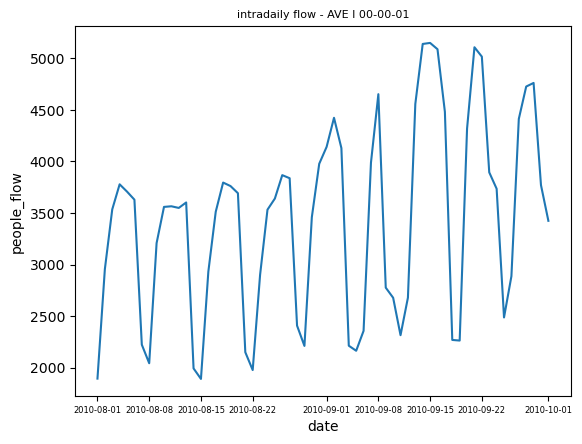

In [22]:
#creating df_check again
station = "AVE I"

df_check = df_final[df_final["station"]==station]
df_check["date"] = pd.to_datetime(df_check["date"])

#filtering a period
start = pd.to_datetime("2010-08-01", dayfirst=False)
end = pd.to_datetime("2010-10-01", dayfirst=False)

df_check = df_check[(df_check["date"] >= start)&(df_check["date"] <= end)]

#visualizing our data
sns.lineplot(x="date", y="people_flow", data=df_check)
plt.xticks(fontsize=6)
plt.title("intradaily flow - AVE I 00-00-01", fontsize=8)

Great! Our transform kept the periodic patterns of our data. Now we can move on in our project and start building up our next notebook, where we will preprocess the other csvs files.